# CMSC 636, HW3: Multilayer perceptron on MNIST dataset

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


## Load MNIST

In [2]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [3]:
sess = tf.InteractiveSession()

In [4]:
input_size= 28*28
n_outputs=  10
n_hidden = 100
batch_size= 100

Define the computation graph. i.e:

h1 = relu(x w1 + b1) </br> logits = h1 w2 + b2 </br>

Where "x w1" is a matrix multiplication between the matices x and w1. The matrix x is a matrix whose rows represent the training input data.

In [5]:
class DenseLayer(object):
    def __init__(self, n_inputs, n_units, afunc=None, w_stddev=0.01):
        self.w = tf.Variable(
            tf.random.truncated_normal([n_inputs, n_units], stddev=w_stddev),
            name='w')
        self.b = tf.Variable(
            tf.zeros([n_units]), 
            name='b')
        self.afunc = afunc
    
    def trainable_variables(self):
        return [self.w, self.b]

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.afunc is not None:
            y = self.afunc(y)
        return y

class LogisticReg(object):
    def __init__(self, layers):
        self.layers = layers
        
    def trainable_variables(self):
        return [var for layer in self.layers 
                for var in layer.trainable_variables()]
        
    def __call__(self, x, logits=False):
        output = x
        for layer in self.layers:
            output = layer(output)
        if not logits:  
            output = tf.nn.softmax(output)
        return output

def loss_fn(logits, labels, weights):
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    reg = 0
    for w in weights:
        reg = reg + tf.nn.l2_loss(w)
    return error + 0.0001*reg
    
    
model = LogisticReg([DenseLayer(input_size, n_hidden, afunc=tf.nn.sigmoid), 
                     DenseLayer(n_hidden, n_hidden, afunc=tf.nn.sigmoid), 
                     DenseLayer(n_hidden, n_outputs)])
weights = [layer.w for layer in model.layers]

optimizer = tf.keras.optimizers.Adam(1e-3)  


## Training

In [6]:
def accuracy_train(predictions, labels):
    if n_outputs == 1:
        return (100.0 * np.sum(np.greater(predictions, 0.5) == np.greater(labels, 0.5))// predictions.shape[0])
    else:
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))// predictions.shape[0])
    
def accuracy_test (predictions, labels):
    if n_outputs == 1:
        return (100.0 * np.sum(np.greater(predictions, 0.5) == np.greater(labels, 0.5))// predictions.shape[0].value)
    else:
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))// predictions.shape[0].value)

In [11]:
num_steps = 10000
summary_freq = 200
n_test_log = 10

def train_step(labels, inputs):
    with tf.GradientTape() as tape:
        logits = model(inputs, logits=True)
        loss = loss_fn(logits, labels, weights)
    gradients = tape.gradient(loss, model.trainable_variables())
    optimizer.apply_gradients(zip(gradients, model.trainable_variables()))
    
    return loss.numpy(), model(inputs).numpy()


import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

n_epoch = []
n_train_accuracy = []
n_test_accuracy = []


mean_loss= 0
train_accuracy= 0
start_time = time.time()
for step in range(num_steps):
    batch_X, batch_y= mnist.train.next_batch(batch_size)    
    l, train_pred = train_step(batch_y, batch_X)
    train_accuracy += accuracy_train(train_pred, batch_y)
    mean_loss += l
    if step%summary_freq == 0:
        train_accuracy= train_accuracy/summary_freq
        test_accuracy= 0
        for i in range(n_test_log):
            batch_X_test, batch_y_test= mnist.test.next_batch(batch_size) 
            pred = model(batch_X_test)
            test_accuracy += accuracy_test(pred, batch_y_test)
        test_accuracy= test_accuracy/n_test_log
        
        n_epoch.append(step)
        n_train_accuracy.append(train_accuracy)
        n_test_accuracy.append(test_accuracy)

        print(step, ', train:',train_accuracy,' | test:', test_accuracy, ' | loss:', mean_loss/summary_freq)
        mean_loss= 0
        train_accuracy= 0
        
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')


0 , train: 0.495  | test: 97.1  | loss: 0.0005455642938613891
200 , train: 99.43  | test: 98.0  | loss: 0.1062304351106286
400 , train: 99.38  | test: 97.6  | loss: 0.10908547300845385
600 , train: 99.56  | test: 97.9  | loss: 0.10124751370400191
800 , train: 99.51  | test: 98.0  | loss: 0.10505104411393404
1000 , train: 99.325  | test: 98.5  | loss: 0.10990501366555691
1200 , train: 99.585  | test: 97.8  | loss: 0.1032341069728136
1400 , train: 99.49  | test: 98.6  | loss: 0.1048854961618781
1600 , train: 99.37  | test: 97.7  | loss: 0.10684656091034413
1800 , train: 99.575  | test: 98.3  | loss: 0.10275710716843606
2000 , train: 99.475  | test: 97.8  | loss: 0.10540733847767114
2200 , train: 99.42  | test: 97.6  | loss: 0.10772873230278492
2400 , train: 99.59  | test: 98.3  | loss: 0.10217385310679675
2600 , train: 99.47  | test: 97.9  | loss: 0.10527668777853251
2800 , train: 99.445  | test: 98.0  | loss: 0.10806653302162886
3000 , train: 99.575  | test: 97.0  | loss: 0.103240890726

## Test the model using testing dataset

Actual number: 5
Prediction by the model: 5


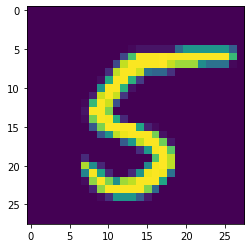

In [8]:
test_sample_x, test_sample_y= mnist.test.next_batch(1) 

pred = model(test_sample_x)

print('Actual number:', np.argmax(test_sample_y))
print('Prediction by the model:', np.argmax(pred))

plt.imshow(np.reshape(test_sample_x, [28,28]))

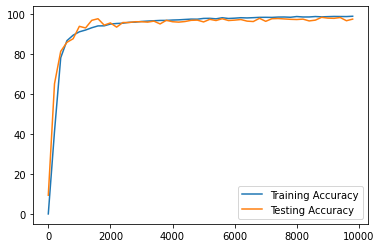

In [9]:
plt.plot(n_epoch, n_train_accuracy, label="Training Accuracy")
plt.plot(n_epoch, n_test_accuracy, label="Testing Accuracy")
plt.legend()
